In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from opt_utils import initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset

%matplotlib inline
plt.rcParams["figure.figsize"] = (7.0, 4.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

### Gradient Descent

In [2]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    l = len(parameters) // 2
    
    for i in range(l):
        parameters["W"+str(i+1)] -= learning_rate * grads["dW"+str(i+1)]
        parameters["b"+str(i+1)] -= learning_rate * grads["db"+str(i+1)]
    
    return parameters

### Mini-Batch Gradient Descent

In [3]:
def random_mini_batches(X, Y, mini_batch_size=64):
    m = X.shape[1]
    mini_batches = []
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

### Momentum

In [4]:
def initialize_velocity(parameters):
    l = len(parameters) // 2
    v = {}
    
    for i in range(l):
        v["dW"+str(i+1)] = np.zeros_like(parameters["W"+str(i+1)])
        v["db"+str(i+1)] = np.zeros_like(parameters["b"+str(i+1)])
    
    return v

In [5]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    l = len(parameters) // 2
    
    for i in range(l):
        v["dW"+str(i+1)] = beta * v["dW"+str(i+1)] + (1-beta) * grads["dW"+str(i+1)]
        v["db"+str(i+1)] = beta * v["db"+str(i+1)] + (1-beta) * grads["db"+str(i+1)]
        
        parameters["W"+str(i+1)] -= learning_rate * v["dW"+str(i+1)]
        parameters["b"+str(i+1)] -= learning_rate * v["db"+str(i+1)]
    
    return parameters

### Adam

In [6]:
def initialize_adam(parameters):
    l = len(parameters) // 2
    v = {}
    s = {}
    
    for i in range(l):
        v["dW"+str(i+1)] = np.zeros_like(parameters["W"+str(i+1)])
        v["db"+str(i+1)] = np.zeros_like(parameters["b"+str(i+1)])
        s["dW"+str(i+1)] = np.zeros_like(parameters["W"+str(i+1)])
        s["db"+str(i+1)] = np.zeros_like(parameters["b"+str(i+1)])
    
    return v,s

In [7]:
def update_parameters_with_adam(parameters, grads, v,s,t, learning_rate=0.01, 
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    l = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}
    
    for i in range(l):
        v["dW"+str(i+1)] = beta1 * v["dW"+str(i+1)] + (1-beta1) * grads["dW"+str(i+1)]
        v["db"+str(i+1)] = beta1 * v["db"+str(i+1)] + (1-beta1) * grads["db"+str(i+1)]
        v_corrected["dW"+str(i+1)] = v["dW"+str(i+1)] / (1-beta1**t)
        v_corrected["db"+str(i+1)] = v["db"+str(i+1)] / (1-beta1**t)
        
        s["dW"+str(i+1)] = beta2 * s["dW"+str(i+1)] + (1-beta2) * (grads["dW"+str(i+1)]**2)
        s["db"+str(i+1)] = beta2 * s["db"+str(i+1)] + (1-beta2) * (grads["db"+str(i+1)]**2)
        s_corrected["dW"+str(i+1)] = s["dW"+str(i+1)] / (1-beta2**t)
        s_corrected["db"+str(i+1)] = s["db"+str(i+1)] / (1-beta2**t)
        
    parameters["W" + str(i + 1)] = parameters["W" + str(i + 1)] - learning_rate * v_corrected["dW" + str(i + 1)] / (np.sqrt(s_corrected["dW" + str(i + 1)]) + epsilon)
    parameters["b" + str(i + 1)] = parameters["b" + str(i + 1)] - learning_rate * v_corrected["db" + str(i + 1)] / (np.sqrt(s_corrected["db" + str(i + 1)]) + epsilon)
    
    return parameters
    

## Model with different optimization algorithms

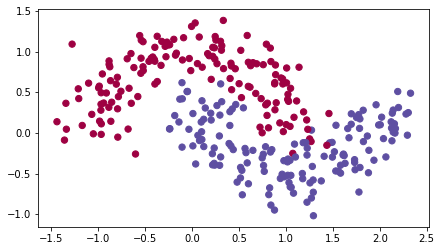

In [8]:
train_X, train_Y = load_dataset()

In [9]:
def model(X, Y, layer_dims, optimizer, learning_rate=0.0004, mini_batch_size=64, beta=0.9,
         beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10000, print_cost=True):
    l = len(layer_dims)
    costs = []
    t = 0
    
    parameters = initialize_parameters(layer_dims)
    
    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v,s = initialize_adam(parameters)
    
    for i in range(num_epochs):
        t += 1
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            a3, caches = forward_propagation(minibatch_X, parameters)
            cost = compute_cost(a3, minibatch_Y)
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)
            
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                parameters = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate,
                                                        beta1, beta2, epsilon)  
        if i % 1000 == 0:
            costs.append(cost)
            if print_cost:
                print("Cost after epoch %i: %f" %(i, cost))
        
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs')
    plt.title('Learning rate: ' + str(learning_rate))
    plt.show()
    
    return parameters

### Mini-batch Gradient Descent

Cost after epoch 0: 0.815779
Cost after epoch 1000: 0.703824
Cost after epoch 2000: 0.686952
Cost after epoch 3000: 0.683149
Cost after epoch 4000: 0.690950
Cost after epoch 5000: 0.676073
Cost after epoch 6000: 0.657168
Cost after epoch 7000: 0.653755
Cost after epoch 8000: 0.613688
Cost after epoch 9000: 0.585320


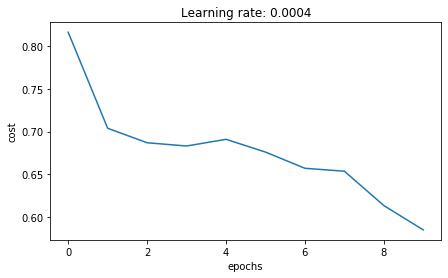

Accuracy: 0.8


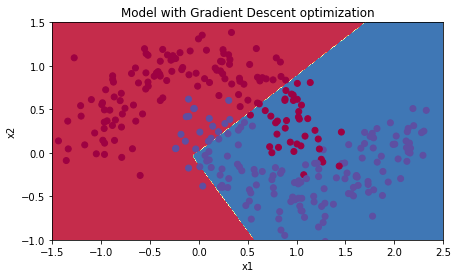

In [10]:
layer_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layer_dims, optimizer = "gd")
predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Mini-batch gradient descent with momentum

Cost after epoch 0: 0.550081
Cost after epoch 1000: 0.531400
Cost after epoch 2000: 0.375709
Cost after epoch 3000: 0.296038
Cost after epoch 4000: 0.247394
Cost after epoch 5000: 0.309435
Cost after epoch 6000: 0.275390
Cost after epoch 7000: 0.314673
Cost after epoch 8000: 0.283221
Cost after epoch 9000: 0.264643


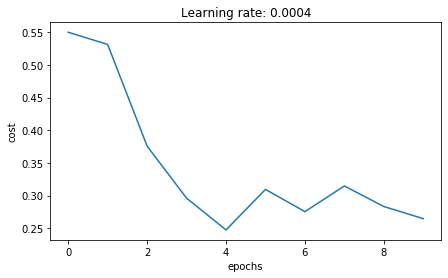

Accuracy: 0.8866666666666667


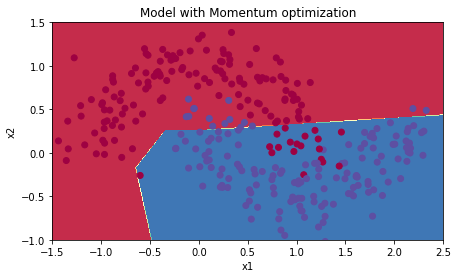

In [11]:
layer_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layer_dims, beta=0.9, optimizer="gd")

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Mini-batch with Adam mode

Cost after epoch 0: 0.688398
Cost after epoch 1000: 0.619520
Cost after epoch 2000: 0.593863
Cost after epoch 3000: 0.553357
Cost after epoch 4000: 0.542613
Cost after epoch 5000: 0.473688
Cost after epoch 6000: 0.455369
Cost after epoch 7000: 0.505617
Cost after epoch 8000: 0.430491
Cost after epoch 9000: 0.467973


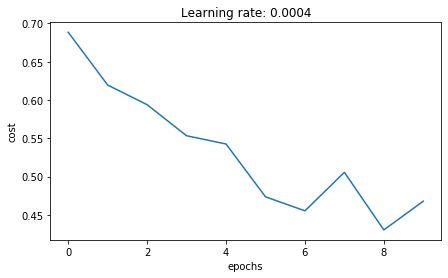

Accuracy: 0.7766666666666666


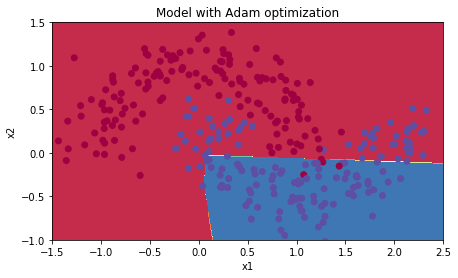

In [12]:
layer_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layer_dims, optimizer="adam")

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

- 왜 Adam의 accuracy가 제일 낮을까